In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.integrate import odeint
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
t_arr = np.linspace(0, 10, 1000)

In [3]:
def dynamics_model_with_damper(X, t, M1, b1, k1, M2, b2, k2, force_arr,t_arr):
    
#     t_arr=list(t_arr)
#     print(t)
#     print(t_arr)
#     idx=t_arr.index(t)
    F=force_arr[0]
    
    
    
    
    if (t in t_arr):
        t_arr=list(t_arr)
        idx=t_arr.index(t)
        F=force_arr[idx]
    else:
        diff_arr=np.absolute(t_arr-t)
        idx=diff_arr.argmin()
        F=force_arr[idx]
#     print(F)
#     deltaT = 1
#     if t <= deltaT:
#         print(t)
#         F = force_arr[int(np.floor(t/deltaT))]
#         print(int(np.floor(t/deltaT)))
#         print(F)
#     else:
#         F = 0
    
    a3 = (M1*b2+(b1+b2)*M2)/(M1*M2)
    a2 = (M1*k2+b1*b2+(k1+k2)*M2)/(M1*M2)
    a1 = (b1*k2+k1*b2)/(M1*M2)
    a0 = (k1*k2)/(M1*M2)
    
    dx1 = X[1]
    dx2 = X[2]
    dx3 = X[3]
    dx4 = -a0*X[0]-a1*X[1]-a2*X[2]-a3*X[3]+F
    
    return [dx1, dx2, dx3, dx4]

In [4]:
def output_model_with_damper(X_arr, M1, b1, k1, M2, b2, k2):
    
    b0 = k2/(M1*M2)
    b1 = b2/(M1*M2)
    b2 = M2/(M1*M2)
    C = np.array([b0, b1, b2, 0])
    
    y_arr = np.matmul(C, np.transpose(X_arr))
    
    return y_arr

In [5]:
def time_dynamics(param,t_arr):
    X0 = [0, 0, 0, 0]
#     t_arr = np.linspace(0, 10, 1000)
    #dt=0.001
    # Generate random force array
    force_arr = np.random.uniform(low=0, high=100, size=len(t_arr))
    
    # With damper
    M1, b1, k1, M2, b2, k2 = param[0], param[1], param[2], param[3], param[4], param[5]
    X_arr = odeint(dynamics_model_with_damper, X0, t_arr, args=(M1, b1, k1, M2, b2, k2, force_arr,t_arr))
    y_arr = output_model_with_damper(X_arr, M1, b1, k1, M2, b2, k2)
    
    return y_arr, force_arr,X_arr

In [6]:
# Skyscraper parameters
M1, b1, k1 = 5.11, 0.767, 2024
# Tuned Mass Damper parameters
M2, b2, k2 = 0.87, 8.9, 185

param = [M1, b1, k1, M2, b2, k2]
y_arr_with_damper, force_arr,x_arr = time_dynamics(param,t_arr)

Text(0, 0.5, 'Displacement (in m)')

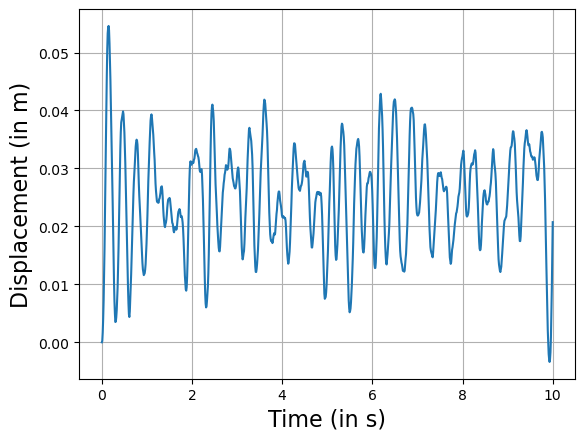

In [7]:
plt.plot(t_arr, y_arr_with_damper, label='With Damper')

plt.grid()

plt.xlabel('Time (in s)', fontsize=16)
plt.ylabel('Displacement (in m)', fontsize=16)

In [8]:
df_state=pd.DataFrame(x_arr,columns=['x1','x2','x3','x4'])
np_inout=np.vstack([force_arr,y_arr_with_damper,t_arr]).T
df_inout=pd.DataFrame(np_inout,columns=['forces_generated','displacemnet','time'])
df=pd.concat([df_inout,df_state],axis=1)
df.head()

,forces_generated,displacemnet,time,x1,x2,x3,x4
0,5.824728,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000
1,76.157828,0.000228,0.01001,4.189816e-09,0.000002,0.001141,0.394930
2,51.326675,0.001687,0.02002,1.792060e-07,0.000044,0.008128,0.920376
3,42.081393,0.004081,0.03003,1.198083e-06,0.000177,0.018786,1.168301
4,78.096130,0.007189,0.04004,4.112970e-06,0.000426,0.031498,1.440507


In [9]:
def wind_reshape(arr,window_size):
    X = []
    for i in range(len(arr) - window_size):
        X.append(arr[i:i+window_size])
    return np.array(X)

In [10]:
window_size=4
forces=wind_reshape(df['forces_generated'],window_size)
displacement=wind_reshape(df['displacemnet'],window_size)

In [11]:
def train_test_split(new_data,df,window_size):
    train_size = 0.8
    num_samples = len(new_data)
    train_samples = int(num_samples * train_size)
    test_samples = num_samples - train_samples
    X_train = new_data[window_size:train_samples]
    y_train = df[['x1', 'x2', 'x3', 'x4']][window_size:train_samples]
    X_test = new_data[train_samples:num_samples - window_size]
    y_test = df[['x1', 'x2', 'x3', 'x4']][train_samples:num_samples - window_size]
    return X_train,X_test,y_train,y_test

In [12]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # Define the neural network model
# class EquationModel(nn.Module):
#     def __init__(self, input_size_y, input_size_u, hidden_size):
#         super(EquationModel, self).__init__()
#         self.fc_y = nn.Linear(input_size_y, hidden_size)
#         self.fc_u = nn.Linear(input_size_u, hidden_size)
#         self.fc_output = nn.Linear(hidden_size, 4)  # Output size: 4

#     def forward(self, y, u):
#         y = torch.flatten(y, start_dim=1)
#         u = torch.flatten(u, start_dim=1)
#         y = torch.relu(self.fc_y(y))
#         u = torch.relu(self.fc_u(u))
#         x = self.fc_output(y + u)
#         return x

# # Example usage
# # Create the model
# input_size_y = k  # Number of past values for Y
# input_size_u = k  # Number of past values for U
# hidden_size = 16  # Number of hidden units
# model = EquationModel(input_size_y, input_size_u, hidden_size)

# # Define the loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# # Generate dummy input data
# batch_size = 10
# seq_length = 5
# input_size = 1  # Single variable
# k = 3  # Number of past values
# y = torch.randn(batch_size, seq_length, input_size)  # Shape: (batch_size, seq_length, input_size)
# u = torch.randn(batch_size, seq_length, input_size)  # Shape: (batch_size, seq_length, input_size)
# x = torch.randn(batch_size, seq_length, 4)  # Shape: (batch_size, seq_length, 4)

# # Convert the data to PyTorch tensors
# y = torch.tensor(y, dtype=torch.float32)
# u = torch.tensor(u, dtype=torch.float32)
# x = torch.tensor(x, dtype=torch.float32)

# # Training loop
# epochs = 1000
# for epoch in range(epochs):
#     # Forward pass
#     outputs = model(y, u)
#     loss = criterion(outputs, x)

#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # Print the loss every 100 epochs
#     if (epoch + 1) % 100 == 0:
#         print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")


In [13]:
forces_train,forces_test,y_train,y_test=train_test_split(forces,df,window_size)
dis_train,dis_test,y_train1,y_test1=train_test_split(displacement,df,window_size)

In [14]:
import torch
import torch.nn as nn

class EquationModel(nn.Module):
    def __init__(self):
        super(EquationModel, self).__init__()
        self.y_branch = nn.Linear(4, 4)  # Input size: 4, Output size: 4
        self.u_branch = nn.Linear(4, 4)  # Input size: 4, Output size: 4

    def forward(self, y, u):
        y_output = self.y_branch(y)
        u_output = self.u_branch(u)
        x = y_output + u_output
        return x

In [15]:
model = EquationModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
forces_train=np.array(forces_train)
forces_test=np.array(forces_test)
y_train=np.array(y_train)
dis_train=np.array(dis_train)
dis_test=np.array(dis_test)
y_test=np.array(y_test)

In [17]:
forces_train = torch.tensor(forces_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
forces_test= torch.tensor(forces_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
dis_test= torch.tensor(dis_test, dtype=torch.float32)
dis_train= torch.tensor(dis_train, dtype=torch.float32)

In [18]:
device='cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

EquationModel(
  (y_branch): Linear(in_features=4, out_features=4, bias=True)
  (u_branch): Linear(in_features=4, out_features=4, bias=True)
)

In [19]:
from tqdm import tqdm

epochs = 50000
for epoch in tqdm(range(epochs),total=epochs):
   
    outputs = model(dis_train, forces_train)
    loss = criterion(outputs, y_train)

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 50000/50000 [00:29<00:00, 1700.43it/s]


In [20]:
y_pred=model(dis_test,forces_test)
y_pred=y_pred.detach().numpy()
from sklearn.metrics import  mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('mean absolute error',mae)
print('mean square error',mse)

mean absolute error 0.103160314
mean square error 0.05736781


In [21]:
torch.save(model.state_dict(), 'equation_model.pth')

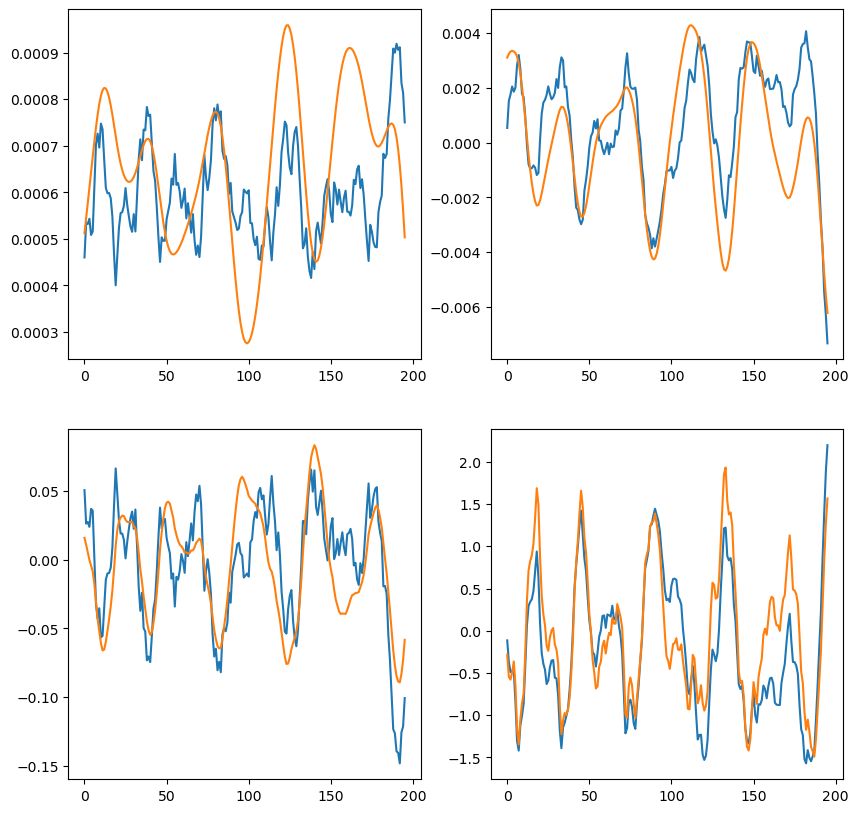

In [22]:
plt.figure(figsize=(10,10))
for i in range(4):
    
    plt.subplot(2,2,i+1)
    plt.plot(y_pred[:,i])
    plt.plot(y_test[:,i])

In [23]:
dis_weights=model.y_branch.weight
dis_weights.shape

torch.Size([4, 4])

In [24]:
forces_weights=model.u_branch.weight
forces_weights.shape

torch.Size([4, 4])

In [32]:
mean_m2, std_m2 = 10, 5
mean_m1, std_m1 = 100, 20
mean_k2, std_k2 = 5000, 1000
mean_k1, std_k1 = 10000, 2000
mean_b1, std_b1 = 4, 1
mean_b2, std_b2 = 20, 5

In [33]:
m1 = np.random.normal(loc=mean_m1, scale=std_m1, size=100)
m2 = np.random.normal(loc=mean_m2, scale=std_m2, size=100)
k1 = np.random.normal(loc=mean_k1, scale=std_k1, size=100)
k2 = np.random.normal(loc=mean_k2, scale=std_k2, size=100)
b1 = np.random.normal(loc=mean_b1, scale=std_b1, size=100)
b2 = np.random.normal(loc=mean_b2, scale=std_b2, size=100)

In [34]:
m1 = np.abs(m1)
m2 = np.abs(m2)
k1 = np.abs(k1)
k2 = np.abs(k2)
b1 = np.abs(b1)
b2 = np.abs(b2)

In [49]:
def app1(t_arr,m1,m2,b1,b2,k1,k2):  
    from tqdm import tqdm 
    df_final = pd.DataFrame()#creating a final so as to append all dataframes
   
    for i in tqdm(range(100),total=100, desc='dataset creation'):
        param = [m1[i], b1[i], k1[i], m2[i], b2[i], k2[i]]#taking params from the set
        
        y_arr_with_damper, force_arr, x_arr = time_dynamics(param, t_arr)
        df_state = pd.DataFrame(x_arr, columns=['x1', 'x2', 'x3', 'x4'])
        #for each iteration setting params in the dataframe
        df_state['M1'] = m1[i]
        df_state['M2'] = m2[i]
        df_state['b1'] = b1[i]
        df_state['b2'] = b2[i]
        df_state['k1'] = k1[i]
        df_state['k2'] = k2[i]
        
        np_inout = np.vstack([force_arr, y_arr_with_damper, t_arr]).T
        df_inout = pd.DataFrame(np_inout, columns=['forces_generated', 'displacemnet', 'time'])
        df=pd.concat([df_inout,df_state],axis=1)
        df_final = df_final.append(df, ignore_index=True)
     
    window_size=4
    new_data=wind_reshape(df_final[['displacemnet','forces_generated','time','M1','M2','b1','b2','k1','k2']],window_size)
    
    forces=wind_reshape(df_final['forces_generated'],window_size)
    displacement=wind_reshape(df_final['displacemnet'],window_size)
    
    params=df_final[['M1','M2','b1','b2','k1','k2']]
    
    forces_train,forces_test,y_train,y_test=train_test_split(forces,df_final,window_size)
    dis_train,dis_test,_,_=train_test_split(displacement,df_final,window_size)
    par_train,par_test,_,_=train_test_split(params,df_final,window_size)
    
    return forces_train, forces_test, dis_train, dis_test, par_train, par_test, y_train, y_test

In [ ]:
forces_train, forces_test, dis_train ,dis_test, par_train, par_test, y_train, y_test=app1(t_arr,m1,m2,b1,b2,k1,k2)

In [54]:
par_train_new=par_train[:79992]
par_train_new.shape

(79992, 6)

In [70]:
# class EquationModel(nn.Module):
#     def __init__(self):
#         super(EquationModel, self).__init__()
#         self.y_branch = nn.Linear(4, 4)  # Input size: 4, Output size: 4
#         self.u_branch = nn.Linear(4, 4)  # Input size: 4, Output size: 4
#         self.parameters_branch = nn.Linear(6, 4)  # Input size: 6, Output size: 8
        
#     def forward(self, y, u, parameters):
#         y_output = self.y_branch(y)
#         u_output = self.u_branch(u)
#         parameters_output = self.parameters_branch(parameters)
      
#         x = y_output+ u_output+ parameters_output
#         return x

In [105]:
class EquationModel(nn.Module):
    def __init__(self):
        super(EquationModel, self).__init__()
        self.normalize_input = nn.BatchNorm1d(4)
        self.normalize_input1 = nn.BatchNorm1d(6)
      
        self.y_branch = nn.Linear(4, 4)
        self.u_branch = nn.Linear(4, 4)
        self.parameters_branch = nn.Linear(6, 4)
      

    def forward(self, y, u, parameters):
        y_normalized = self.normalize_input(y)
        u_normalized = self.normalize_input(u)
        parameters_normalized = self.normalize_input1(parameters)

        y_output = self.y_branch(y_normalized)
        u_output = self.u_branch(u_normalized)
        parameters_output = self.parameters_branch(parameters_normalized)

        combined_output = y_output + u_output + parameters_output
        x = combined_output
        
        return x

In [106]:
model = EquationModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [60]:
forces_train=np.array(forces_train)
forces_test=np.array(forces_test)

y_train=np.array(y_train)
y_test=np.array(y_test)

dis_train=np.array(dis_train)
dis_test=np.array(dis_test)

par_train_new=np.array(par_train_new)
par_test=np.array(par_test)

In [61]:
forces_train = torch.tensor(forces_train, dtype=torch.float32)
forces_test= torch.tensor(forces_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

dis_test= torch.tensor(dis_test, dtype=torch.float32)
dis_train= torch.tensor(dis_train, dtype=torch.float32)

par_train_new= torch.tensor(par_train_new, dtype=torch.float32)
par_test= torch.tensor(par_test, dtype=torch.float32)

In [107]:
epochs = 10000
for epoch in tqdm(range(epochs),total=epochs):
 
    outputs = model(dis_train, forces_train, par_train_new)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 10000/10000 [07:06<00:00, 23.43it/s]


In [97]:
y_pred=model(dis_test,forces_test,par_test)
y_pred=y_pred.detach().numpy()
from sklearn.metrics import  mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('mean absolute error',mae)
print('mean square error',mse)

mean absolute error 0.36407277
mean square error 0.8131944


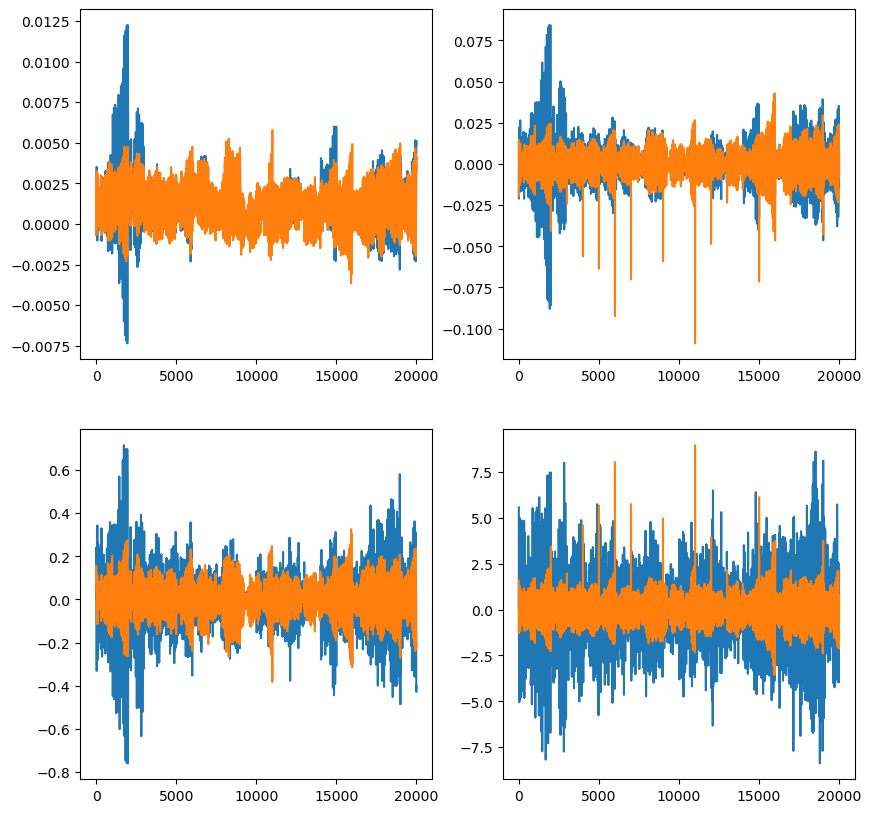

In [98]:
plt.figure(figsize=(10,10))
for i in range(4):
    
    plt.subplot(2,2,i+1)
    plt.plot(y_test[:,i])
    plt.plot(y_pred[:,i])

In [99]:
torch.save(model.state_dict(), 'equation_model.pth')